In [1]:
from pylab import *
def ls(A): 
    "Normalize a matrix to be a stochastic matrix."
    return A*1.0/maximum(1e-6,sum(A,0)[newaxis,:])
def vs(v): 
    "Normalize a vector to sum to 1."
    return v*1.0/maximum(1e-6,sum(v))
def unary(i,n):
    "Generate a unary vector."
    assert i<n
    v = zeros(n)
    v[i] = 1
    return v

Hidden Markov Models
====================

- speech recognition
- online handwriting recognition
- OCR
- DNA sequence analysis

Training Data
=============

Let's build an HMM model of a character.  To do this, we need to construct training data that we can use in the rest of this worksheet.
For that, we use a page of 30 rows of 26 upper case letters, arranged in a widely spaced grid.

In [19]:
letter = imread("letter.png")
letter = mean(letter,2)
letter = letter*1.0/amax(letter)
letter = 1.0-letter

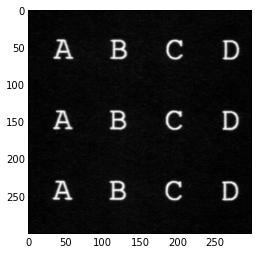

In [20]:
gray()
imshow(letter[:300,:300])

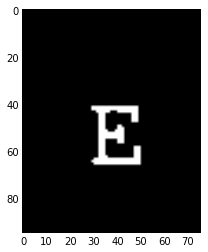

In [21]:
h,w = letter.shape
ch,cw = h//30,w//26
lines = [letter[i*ch:(i+1)*ch,:] for i in range(30)]
chars = [[l[:,j*cw:(j+1)*cw] for j in range(26)] for l in lines]
chars = array(chars)
chars = array(chars>0.5*amax(chars),'B')
Es = chars[:,4,:,:]
gray()
imshow(Es[5])

The individual letters aren't centered, so let's do that next.

In [22]:
from scipy.ndimage import measurements,interpolation

def centered(image,size=None):
    center = array(measurements.center_of_mass(image))
    tcenter = array(image.shape)/2
    delta = tcenter-center
    shifted = interpolation.shift(image,delta)
    if size is None: return shifted
    h,w = shifted.shape
    th,tw = size
    ch,cw = h//2-th//2,w//2-tw//2
    return shifted[ch:ch+th,cw:cw+tw]

We now have a stack of letters "E" in sequence.  We put them together into a long row of letters.

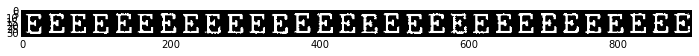

In [23]:
Es = [centered(E,size=(35,30)) for E in Es]
signal = hstack(Es).T
figsize(12,8)
imshow(signal.T)

Next, we are going to transform vertical slices through this input into tokens, namely by clustering.

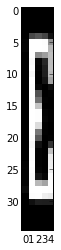

In [25]:
from sklearn import cluster
km = cluster.KMeans(k=5)
km.fit(signal)
centers = km.cluster_centers_
figsize(4,4)
imshow(centers.T,interpolation='nearest')

We can now represent the signal as a sequences of numbers, each indicating
which cluster center represents that particular slice best.

In [26]:
outputs = km.predict(signal)
print outputs[:35]

[0 0 0 0 0 0 3 3 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 4 4 4 0 0 0 0 0 0 0 0 0]


We have a fairly reasonable number of examples for each slice type.

In [27]:
from collections import Counter
Counter(outputs)

Counter({0: 278, 2: 230, 3: 194, 4: 102, 1: 96})

We can also reconstruct the original signal in terms of these slices.

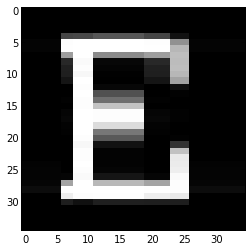

In [29]:
imshow(centers[outputs[:35]].T,interpolation='nearest')

Manual Construction of a Model
================================

We'd like some kind of model that represents characters fairly well.  How can we construct it?

Let's start by constructing the "average character" and look at the sequence of slice codes it corresponds to.

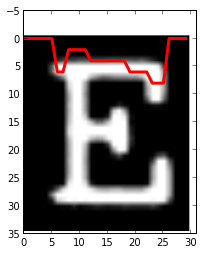

In [31]:
Em = mean(array(Es),0)
figsize(4,4); imshow(Em)
s = km.predict(Em.T)
s
xlim(0,len(s)+1)
plot(2*s,color='r',linewidth=3)

Now we don't know how many repeats of these slices we actually need.

Well, we do approximately, but for the sake of argument, let's construct a generic model
that just represents the sequences of slices.

[0 3 1 2 3 4]


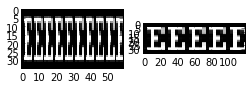

In [33]:
# find where the VQ code changes
s0 = s[s!=roll(s,-1)]
print s0
figsize(4,4)
# display just the repeated slice sequence
subplot(121); imshow(tile(centers[s0],(10,1)).T,interpolation='nearest')
from itertools import chain
# repeat each slice four times
sr = array(list(chain(*[[x]*4 for x in s0])),'i')
subplot(122); imshow(tile(centers[sr],(5,1)).T,interpolation='nearest')

Durational Models
==================

In the figure above, for the first case, we have 1 state per output.  This yields a very
compressed image.  We need a _durational model_ (thinking of the $x$ axis as time).

The second case uses exactly three states for each output, giving rise to perfectly uniformly
spaced outputs.

For our first attempt, we are going to use self transitions; these allow variable durations
in each state.  However, the probability distribution for how long we stay in a state 
has an exponential distribution.

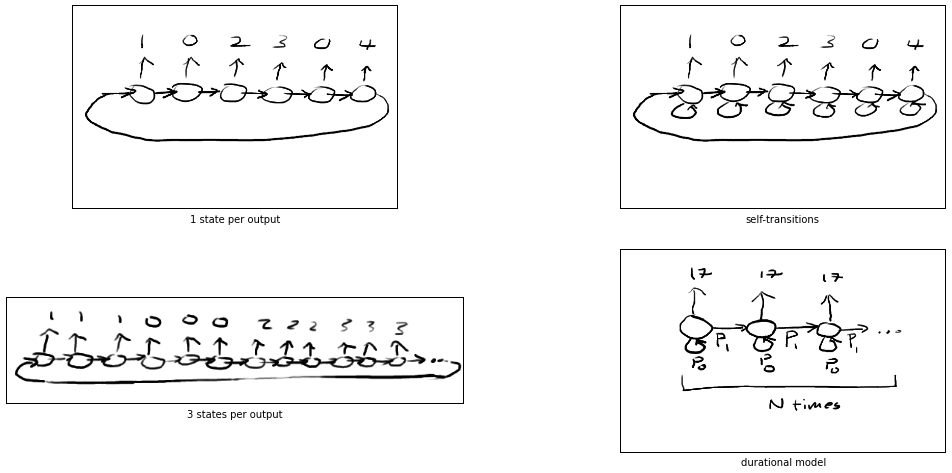

In [34]:
figsize(18,8)
subplot(221); xticks([]); yticks([]); imshow(imread("Figures/states-1.png")); xlabel("1 state per output")
subplot(222); xticks([]); yticks([]); imshow(imread("Figures/states-2.png")); xlabel("self-transitions")
subplot(223); xticks([]); yticks([]); imshow(imread("Figures/states-3.png")); xlabel("3 states per output")
subplot(224); xticks([]); yticks([]); imshow(imread("Figures/states-4.png")); xlabel("durational model")

However, by using combinations of states that output the same symbol,
we can approximate arbitrary distributions.

Particularly simple to approximate is a normal distribution for a durational
model, because of the central limit theorem about sums of random variables.

The duration in the individual state is exponentially distributed.

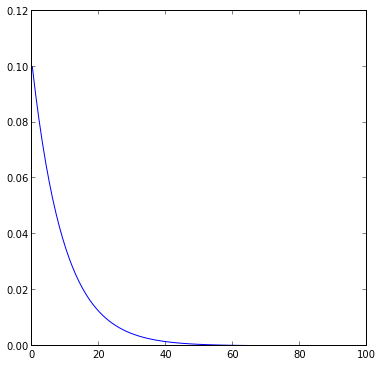

In [35]:
figsize(6,6)
p0 = 0.9
decay = vs(array([p0**n for n in range(100)]))
plot(decay)

But if we add up the durations of multiple states, we get a peaked distribution
that approximates a normal distribution.

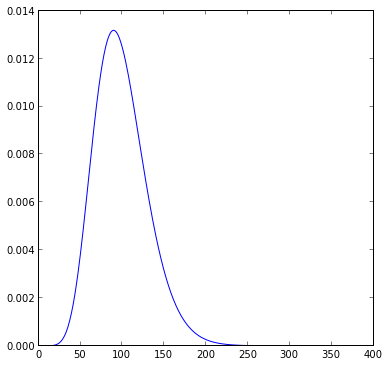

In [36]:
figsize(6,6)
result = vs(decay)
for i in range(10):
    result = vs(convolve(result,decay))
plot(result[:400])

Transition Matrix for Manual Model
==================================

So for now, let's just build a model similar to the model below.

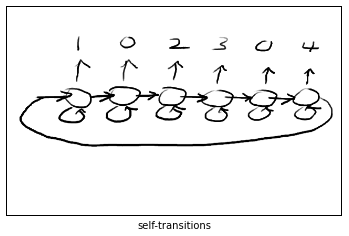

In [37]:
figsize(6,6)
xticks([]); yticks([]); imshow(imread("Figures/states-2.png")); xlabel("self-transitions")

This is not going to match the "durations" of our character models very well,
but we can still have the learning algorithms optimize it.

In [38]:
ns = len(s0) # number of states
no = len(centers) # number of centers

Here, we implement the state transition matrix.
Note that we set a "probability floor", since we are going to use
the matrix for estimation later, and zeros (=something that never happens)
don't work so well.

This transition matrix can be thought of as a linear function that
maps old states into new states.

Note that a lot of literature on Markov models uses the opposite
convention for subscripts.  Our transition matrices are multiplied
from the left with a column vector of old states and yield a new state.

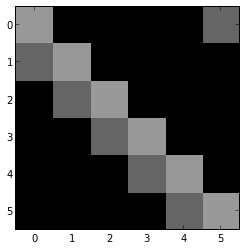

In [49]:
A = zeros((ns,ns))
for i in range(ns):
    A[i,i] = 0.6
    A[(i+1)%ns,i] = 0.4
A = ls(maximum(1e-3,A))
figsize(4,4)
imshow(A,interpolation='nearest',vmin=0,vmax=1)

We still need to write down how the individual states correspond to output symbols.
In fact, in our case, that's quite simple, since each state corresponds to a single output
symbol (but not the other way around).

The `B` matrix is what makes Hidden Markov Models different from Markov chains.
In Markov chains, we can observe what state the chain is in.
In a Hidden Markov Model, we have imperfect information about the state of
the system.
`B` is a kind of "confusion matrix" or "error matrix" for observing the state of the system.
It's really the simplest such system; there may be much more general kinds of observations
and errors we can make.

In HMMs for speech recognition, the "observations" are actually usually the "slices"
(short time spectrum) at a given time, and instead of approximating that as an output
symbol via clustering (see above), the relationship between the observation vector $b$
and the state is modeled directly.

[0 3 1 2 3 4]


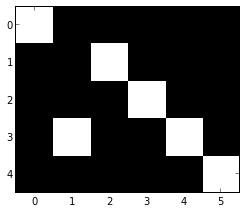

In [50]:
B = zeros((no,ns))
for i in range(ns): B[s0[i],i] += 1.0
B = ls(maximum(1e-2,B))
figsize(4,4)
imshow(B,interpolation='nearest')
print s0

Sampling from the Distribution
==============================

First, let's define a simple function to sample from discrete distributions in general.

In [51]:
def rsample(dist):
    v = add.accumulate(dist)
    assert abs(v[-1]-1)<1e-3
    val = rand()
    return searchsorted(v,val)

Sampling from Hidden Markov Models happens in two stages.

First, we sample the state sequence.

Then, given the state sequence, we sample the observations.

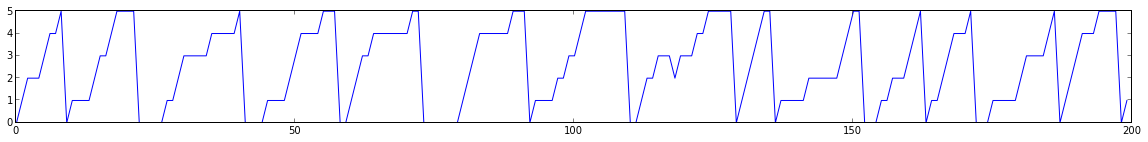

In [52]:
def chain_sample(A,n,state=0):
    states = zeros(n,'i')
    for i in range(n):
        p = A[:,state]
        state = rsample(A[:,state])
        states[i] = state
    return states
figsize(20,2)
plot(chain_sample(A,200))

Here is code for sampling both the state sequence and the sequence of observations.

In [53]:
def hmm_sample2(A,B,n,state=0):
    states = chain_sample(A,n,state=state)
    outputs = array([rsample(B[:,s]) for s in states])
    return array(outputs,'i'),states
def hmm_sample(A,B,n,state=0):
    return hmm_sample2(A,B,n,state=state)[0]

In [54]:
hmm_sample(A,B,20,state=s[0])

array([0, 3, 1, 1, 1, 2, 3, 3, 3, 4, 4, 0, 3, 2, 1, 2, 2, 3, 4, 4], dtype=int32)

We can now generate new, random images from this.

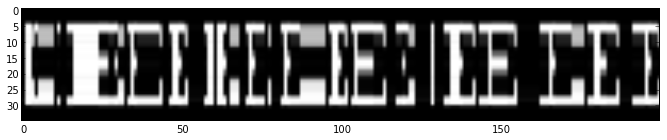

In [55]:
imshow(centers[hmm_sample(A,B,200,state=s[0])].T)

It's a little hard to tell whether this sometimes looks wrong because of the observations
or because of the state sequence, so here is another sampling function that outputs the
"best" observation for each state.

In [56]:
def best_sample(A,B,n,state=0):
    states = chain_sample(A,n,state=state)
    outputs = array([argmax(B[:,s]) for s in states])
    return array(outputs,'i')

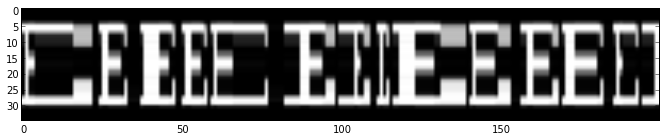

In [57]:
imshow(centers[best_sample(A,B,200,state=s[0])].T)

Since that looks kind of noisy, you might be wondering whether the model is doing anything at all.
Here is the output from a completely random HMM, but using the same output symbols.

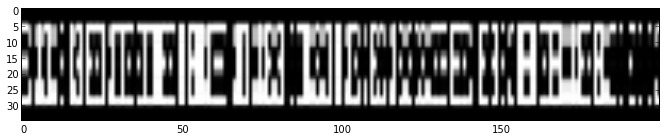

In [58]:
imshow(centers[hmm_sample(ls(rand(5,5)),ls(rand(no,5)),200,state=s[0])].T)

Forward Algorithm
========================

To get started, let's compute what's known as the _forward algorithm_.

This algorithm computes $P(s_t | o_t ... o_1)$, that is, it updates our current
estimate of what state the system is in based on the current and all previous observations.

To do this, it starts of with an initial state distribution (e.g., uniform), and
then computes the posterior of the distribution given the observation:

$$P(s_1|o_1) = \frac{P(o_1|s_1) P(s_1)}{P(o_1)}$$

Here:

- $P(s_1)$ is our prior
- $P(o_1)$ is the first observation
- $P(o_1|s_1)$ is given by the observation matrix $B$

As usual, we don't bother computing $P(o_1)$ explicitly and
instead just normalize.

Now, to do the same thing for $P(s_2|o_1,o_2)$, we reduce this to the above
problem, by observing that all the information about $o_1$ is already contained
in $P(s_1|o_1)$.  

However, $P(s_1|o_1)$ is the state distribution prior
to the state transition, so in order to get a "$P(s_2)$ prior", we
need to multiply $P(s_2|s_1)P(s_1|o_1)$.

This then gives us the complete forward algorithm:

- obtain a new prior by computing $P(s_t|s_{t-1})P(s_{t-1}|o_{t-1})$ using the $A$ matrix
- update the new state using Bayes rule and the observation $o_t$
- repeat

In [59]:
def hmm_forward(A,B,observations,p=None):
    if p is None: p = dot(A,ones(len(A))/len(A))
    fps = []
    for i,o in enumerate(observations):
        # update P(state|ovservation) using Bayes formula
        p = B[o,:]*p
        p /= sum(p)
        fps.append(p)
        # now compute the probabilities in the next state
        p = dot(A,p)
    return array(fps)

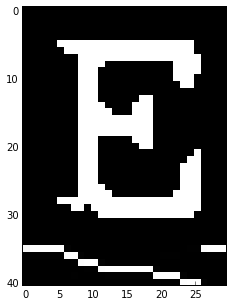

In [60]:
figsize(6,6)
fps = hmm_forward(A,B,outputs)
figsize(5,5)
imshow(r_[signal[:30].T,fps[:30].T/amax(fps)],interpolation='nearest')

Note that there are several things that this is _not_:

- the sequence of most probable states at time $t$ does _not_ necessarily belong to any sequence of states that can acctually even occur ("path")
- the most probable state at time $t$ is _not_ necessarily the "best" state given the observations

C.f.

- "The old man the boat."
- "The horse raced past the barn fell."

Viterbi Decoding
===================

Let's now look at the problem of actually finding the best path.

The algorithm for this is quite similar to what we have already seen for string edit distance and dynamic time warping.

In [61]:
print ns,no
print len(outputs),amax(outputs)+1

6 5
900 5


What we want to find is the sequence of states $s$ such that the likelihood of that
state sequence given the observation is maximized:

$$\hat{s} = \arg\max_s \prod_t P(o_t|s_t) P(s_t|s_{t-1})$$

The key insight is that once we know the best path to each of the states at time $t-1$,
the subsequent search doesn't depend on it.

So, we maintain the accumulated probabilities in an array $p_t(s)$ (called `probs` in the code).

In addition, we maintain information about which state at times $t-1$ actually
gave rise to the best way of coming to each of the states at time $t$ (called `pred` in the code).
By tracing backwards, we can reconstruct the entire best path.

In [62]:
probs = zeros((len(outputs),ns))
pred = zeros((len(outputs),ns))

In [63]:
probs[0] = vs(ones(ns))*B[outputs[0]]
probs[0]

array([ 0.16025641,  0.00160256,  0.00160256,  0.00160256,  0.00160256,
        0.00160256])

In [64]:
for t in range(1,len(outputs)):
    for j in range(ns):
        for k in range(ns):
            c = probs[t-1,k]*A[j,k]*B[outputs[t],j]
            if c>probs[t,k]:
                probs[t,k] = c
                pred[t,k] = j

Let's look at the probabilities.

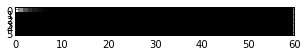

In [65]:
xlim([0,60]); figsize(12,12)
imshow(probs[:60].T,interpolation='nearest')

That's not very good; the probabilities become very small quickly
because we are multiplying together.
At the end, there is no information left.

In [66]:
probs[-1]

array([ 0.,  0.,  0.,  0.,  0.,  0.])

We need to rewrite the algorithm to use logarithms.  With that, we obtain:

In [67]:
costs = 999999*ones((len(outputs),ns))
pred = zeros((len(outputs),ns))
costs[0] = -log(vs(ones(ns))*B[outputs[0]])
print costs[0]

[ 1.83098018  6.43615037  6.43615037  6.43615037  6.43615037  6.43615037]


In [68]:
for t in range(1,len(costs)):
    for j in range(ns):
        for k in range(ns):
            c = costs[t-1,j]-log(A[k,j]*B[outputs[t],j])
            if c<costs[t,k]:
                costs[t,k] = c
                pred[t,k] = j

Now we can actually look at the costs in a sensible way.

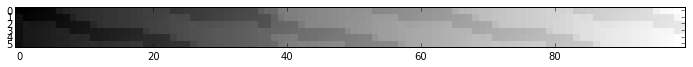

In [74]:
imshow(costs[:100].T,interpolation='nearest')

We can also trace the predecessors back.

In [79]:
t = len(costs)-1
state = argmin(costs[t])
states = []
while t>0:
    state = pred[t,state]
    states.append(state)
    t -= 1
states.append(0)
states = array(states,'i')[::-1]

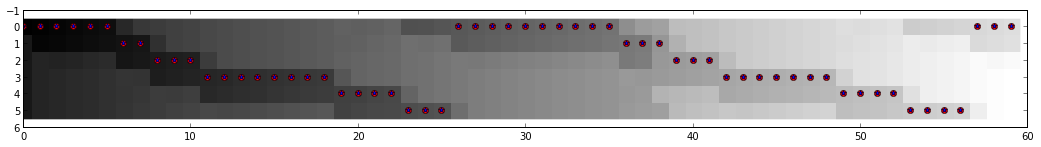

In [80]:
figsize(18,8)
xlim(0,60)
imshow(costs[:60].T,interpolation='nearest')
plot(states[:60],'ro')
plot(argmin(costs[:60],1),'b*')

Note that the state estimates above almost agree, but not quite: the minimum cost state is not always on the best path.

Plotting the state transitions and preferred output labels on top of the data is also useful.

In [81]:
bout = argmax(B[:,states[:60]],0)

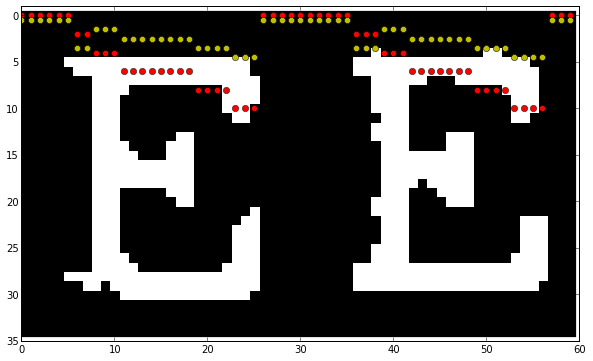

In [82]:
figsize(10,8); xlim((0,60)); ylim((35,-1))
imshow(signal[:60].T,interpolation='nearest')
plot(2*states[:60],'ro')
plot(bout+0.5,'yo')

Here is everything wrapped up into a single function.

In [83]:
def hmm_viterbi(A,B,outputs):
    ns,ns1 = A.shape
    no,ns2 = B.shape
    assert ns==ns1
    assert ns==ns2
    costs = 999999*ones((len(outputs),ns))
    pred = zeros((len(outputs),ns))
    costs[0] = -log(vs(ones(ns))*B[outputs[0]])
    # propagate the costs forward with dynamic programming
    for t in range(1,len(costs)):
        for j in range(ns):
            ck = costs[t-1,j]-log(A[:,j]*B[outputs[t],:])
            pred[t] = where(ck<costs[t],j,pred[t])
            costs[t] = minimum(ck,costs[t])
    # trace the states backwards
    t = len(costs)-1
    state = argmin(costs[t])
    states = []
    while t>0:
        state = pred[t,state]
        states.append(state)
        t -= 1
    states = array(states,'i')[::-1]
    return states

Let's make sure it still works.

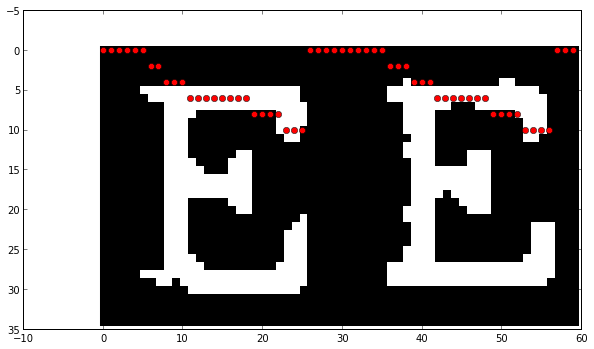

In [84]:
imshow(signal[:60].T,interpolation='nearest')
states = hmm_viterbi(A,B,outputs)
figsize(6,6)
plot(2*states[:60],'ro')

Viterbi Training
================

The Viterbi algorithm gives us a simple way of "learning" the matrices `A` and `B`.
This is called _Viterbi training_.  While commonly used in some applications, it 
differs from the Baum-Welch procedure originally used for training Hidden Markov Models.

(You can think of Viterbi training as being analogous to $k$-means and Baum Welch 
being analogous to Gaussian mixture model; the latter uses "soft assignment".)

The idea behind Viterbi training is that, once we have aligned our observations with the data, we have an estimate
of the hidden, unobservable variable, namely the sequence of states.
Once we have that, we can directly update the `A` and `B` matrices simply by counting.

In [85]:
states = hmm_viterbi(A,B,outputs)
A1 = zeros(A.shape)
for t in range(1,len(states)):
    A1[states[t],states[t-1]] += 1
A1 = ls(A1)
B1 = zeros(B.shape)
for t in range(0,len(states)):
    B1[outputs[t],states[t]] += 1
B1 = ls(B1)

In [86]:
A1[:,1]

array([ 0.        ,  0.62025316,  0.37974684,  0.        ,  0.        ,  0.        ])

Here is a comparison of the transition matrix before and after.
The structure hasn't changed much, but the probabilities have been adjusted.

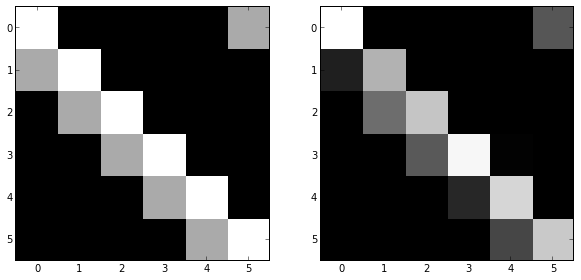

In [87]:
figsize(10,8)
subplot(121); imshow(A,interpolation='nearest')
subplot(122); imshow(A1,interpolation='nearest')

As a consequence, the durational model has improved.

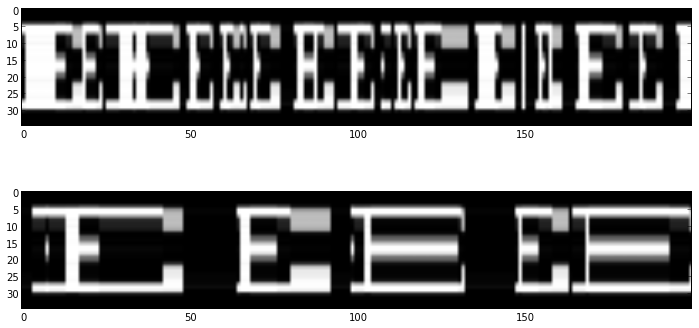

In [88]:
figsize(12,6)
subplot(211); imshow(centers[hmm_sample(A,B,200,state=s[0])].T)
subplot(212); imshow(centers[hmm_sample(A1,B1,200,state=s[0])].T)

Let's wrap this up as well.

In [89]:
def hmm_viterbi_training(A,B,outputs):
    states = hmm_viterbi(A,B,outputs)
    A1 = ones(A.shape)
    for t in range(1,len(states)):
        A1[states[t],states[t-1]] += 1
        A1 = ls(A1)
    B1 = ones(B.shape)
    for t in range(0,len(states)):
        B1[outputs[t],states[t]] += 1
    B1 = ls(B1)
    return A1,B1

Forward-Backward Algorithm
=============================

Above, we already saw how we can compute the _forward probabilities_

$$P(s_t|o_{t-1}...o_1)$$

What we might want to ask instead, however, is the probability that
the system is in state $s_t$ given all observations:

$$P(s_t|o_N...o_1)$$

This is what the _forward backward algorithm_ does for us.

We observe that

$$P(s_t=s) = \frac{P(o_N...o_t|s_t) P(s_t|o_{t-1}...o_1)}{P(o_N...o_1)} = \frac{P(o_N...o_t|s_t) P(s_t|o_{t-1}...o_1)}{P(o_N...o_1)}$$

The second factor is the forward probabilities that we have already computed.

The first factor is an accumulated likelihood over a path.   It is similar to the forward computation
in the Viterbi algorithm, but instead of finding the best path, we add up the contributions from all paths
that arrive in a particular state (we couldn't do that in the Viterbi algorithm because then we wouldn't
have had a way of tracing back the best path).  To propagate the probabilites backwards, we use the
transpose of the state matrix.

In the algorithm below, we renormalize the first factor after each step to avoid underflow.

In [90]:
def hmm_forward_backward(A,B,observations):
    p = dot(A,ones(len(A))/len(A))
    fps = []
    bps = []
    # the forward step
    for i,o in enumerate(observations):
        # update P(state|ovservation) using Bayes formula
        p = B[o,:]*p
        p /= sum(p)
        fps.append(p)
        # now compute the probabilities in the next state
        p = dot(A,p)
    fps = array(fps)
    # the backward step
    p = ones(len(A))
    bps = []
    for i,o in enumerate(observations[::-1]):
        # update P(state|ovservation) using Bayes formula
        p = B[o,:]*p
        p /= sum(p)
        bps.append(p)
        # now compute the probabilities in the previous
        p = dot(A.T,p)
    bps = array(bps)[::-1]
    smoothed = array(fps)*array(bps)
    smoothed /= sum(smoothed,1)[:,newaxis]
    return smoothed,fps,bps

Given our nice state sequence above, this would look completely boring, so let's run this with some noisy transition matrix.

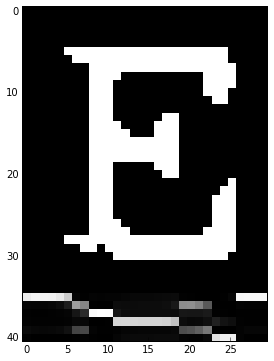

In [91]:
figsize(6,6)
A2,B2 = ls(A1+0.5*rand(*A1.shape)),ls(B1+0.5*rand(*B1.shape))
smoothed,fps,bps = hmm_forward_backward(A2,B2,outputs)
imshow(r_[signal[:30].T,smoothed[:30].T/amax(smoothed)],interpolation='nearest')

Here you can see the contributions of the forward and backward directions.

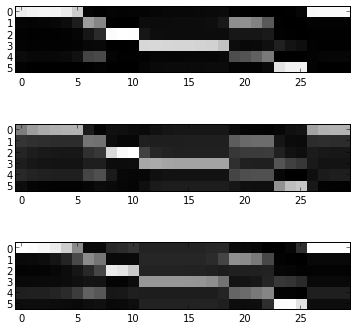

In [92]:
subplot(311); imshow(smoothed[:30].T,interpolation='nearest')
subplot(312); imshow(fps[:30].T,interpolation='nearest')
subplot(313); imshow(bps[:30].T,interpolation='nearest')

Compared to the _forward algorithm_, this algorithm does take advantage of all the information in the label sequence.

However, it is still not guaranteed that the states that maximize the posterior probability at each time $t$ actually
are all on the best path.

Baum-Welch Reestimation
=======================

The _forward backward algorithm_ now gives us everything we need for the second HMM training
algorithm, _Baum Welch reestimation_.

The idea here is similar to Viterbi training, but with two important differences:

- instead of the sequence of states on the best path, we use the most probable states at each time $t$
- instead of "hard updates" (0/1 indicator whether we are in a state), we update using the state probabilities computed by the forward backward algorithm.

In [93]:
ns = 5
A0 = A.copy()
B0 = B.copy()

In [94]:
_,fps,bps = hmm_forward_backward(A0,B0,outputs)

The re-estimate of the matrix $B$ is quite simple: we compute the probability of being in state $s$ at times $t$
and then update the "soft counts" in the new `B` matrix.

In [95]:
def re_B(A,B,outputs,fps,bps):
    B1 = zeros(B.shape,'f')
    for t in range(1,len(outputs)):
        state = vs(fps[t]*bps[t])
        B1[outputs[t]] += state
    return ls(maximum(1e-3,B1))

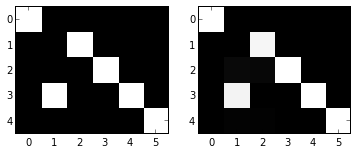

In [96]:
B1 = re_B(A0,B0,outputs,fps,bps)
subplot(121); imshow(B0,interpolation='nearest')
subplot(122); imshow(B1,interpolation='nearest')

The re-estimation for the matrix $A$ is slightly trickier, since we are updating counts
for a transition.

To do this, the correct procedure can be described as follows (I will not prove that here):

- we compute the forward probabilities to get into states at time $t-1$
- we compute the backwards probabilities to get into states at time $t$ and combine that with the observation at time $o_t$

We might now just want to update by taking the outer product of the state vector at times $t-1$ and $t$ and add
that as soft counts to our new transition matrix.  If all the values were 0/1 (as in Viterbi training), that would be correct. 
However, for soft updates, we also need to take into account the existing weight assigned to the transition by the existing
transition matrix $A$ (we counted that in neither the forward nor the backward computations).

Therefore, the full reestimation for the matrix $A$ looks like this:

In [97]:
def re_A(A,B,outputs,fps,bps):
    A1 = zeros(A.shape)
    for t in range(1,len(outputs)):
        state0 = vs(fps[t-1])
        state1 = vs(bps[t]*B[outputs[t],:])
        A1 += vs(outer(state1,state0)*A)
    return ls(maximum(1e-3,A1))

Running one reestimation step has an effect similar to what the Viterbi update had: some of the weights get updated,
but the overall structure of the transition matrix isn't changing much.

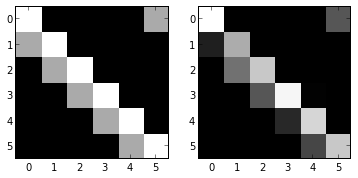

In [98]:
A1 = re_A(A0,B0,outputs,fps,bps)
subplot(121); imshow(A0,interpolation='nearest')
subplot(122); imshow(A1,interpolation='nearest')

Let's do some more updates and see what we get.

In [99]:
def reestimate(A,B,outputs):
    smoothed,fps,bps = hmm_forward_backward(A,B,outputs)
    return re_A(A,B,outputs,fps,bps),re_B(A,B,outputs,fps,bps)

In [100]:
for i in range(50):
    A1,B1 = reestimate(A1,B1,outputs)

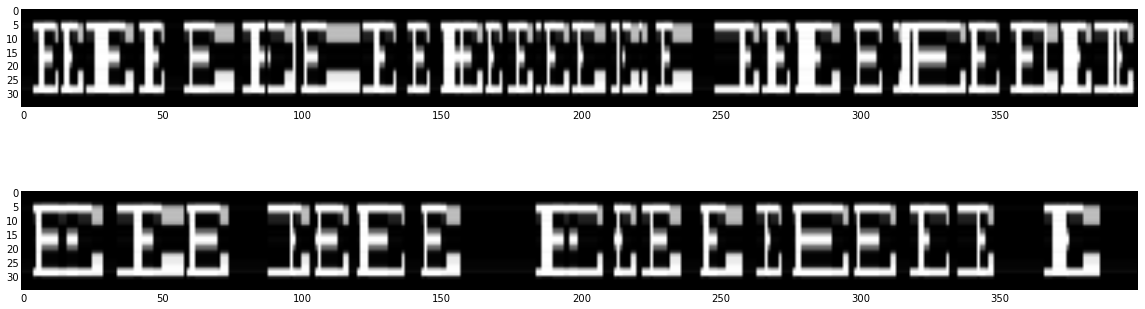

In [101]:
figsize(20,6)
subplot(211); imshow(centers[hmm_sample(A0,B0,400)].T)
subplot(212); imshow(centers[hmm_sample(A1,B1,400)].T)

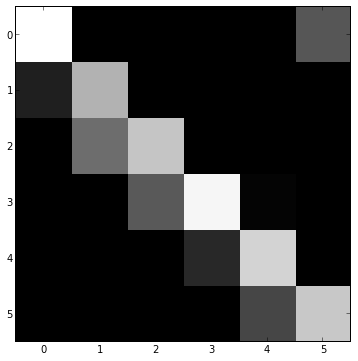

In [103]:
imshow(A1,interpolation='nearest')

As before, the reestimated model gives much nicer outputs than the model we started with.

The odd variation in character size is a consequence of the fact that the width of each part of the letter varies randomly with an exponential distribution.
Given the small number of states our model has, this is pretty close to what can be achieved.

Constrained Models and Parameter Tying
================

A simple way of dealing with this would seem to be to adopt a more complicated model with more states and transitions,
as suggested above in the section on durational models.

The problem with that is that we have limited training data, and increasing, say, to 100 states requires then that we estimate
10000 transition probabilities; we don't have enough training data to do that.

The way out of this dilemma is to constrain the structure of the transition matrices (i.e., force some of their elements
to be small or zero) and/or to "tie" parameters together.

Here, I will illustrate a simple constraint on the state transition matrix, a restricted for of Bakis model.

To do this, we generate a mask of those values in the final transition matrix that are allowed to be non-zero.
This matrix allows self loops and circular progression through a sequence of staes.

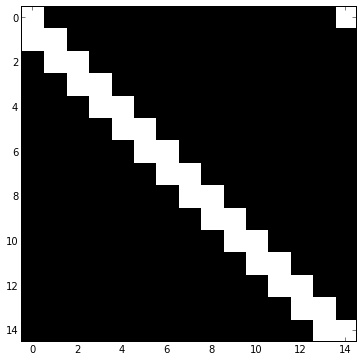

In [104]:
ns = 15
from scipy import linalg
v = zeros(ns)
v[:2] = 1.0
bakis = linalg.circulant(v)
imshow(bakis,interpolation='nearest')

Now we start with a completely random set of weights, albeit constrained by the form of the parameters above.

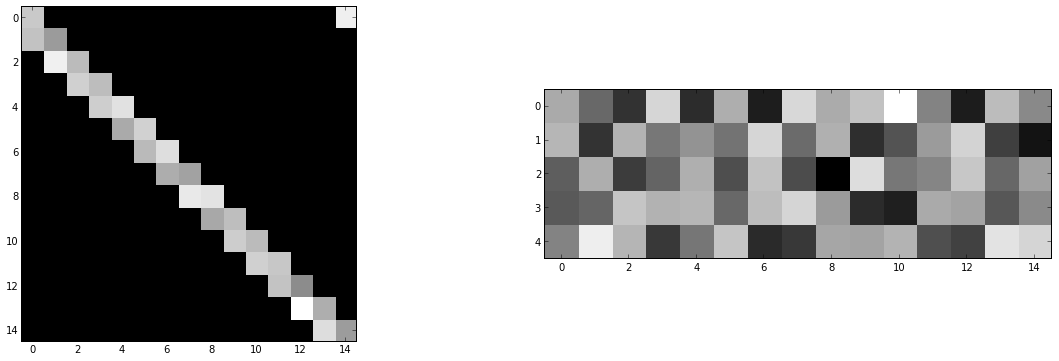

In [105]:
A0 = ls((1.0+rand(ns,ns))*bakis)
B0 = ls(1.0+rand(no,ns))
subplot(121); imshow(A0,interpolation='nearest')
subplot(122); imshow(B0,interpolation='nearest')

To estimate the parameters of this constrained model, we estimate the parameters of a general
model and then gradually restrict the model into its desire form.
That's not the best way of doing this computation (for that, you should modify the
forward backward and reestimation procedures), but it will do here.

In [106]:
A1,B1 = A0,B0
for i in range(2,200):
    A1,B1 = reestimate(A1,B1,outputs)
    A1 = ls(A1*maximum(1.0/i,bakis))

These are the final transition matrices.

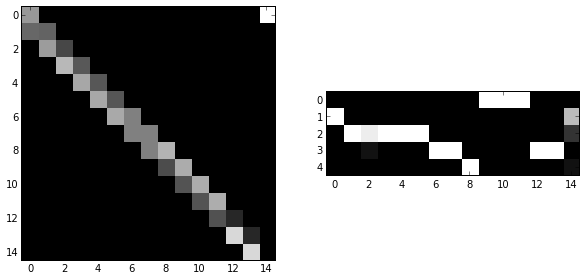

In [107]:
figsize(10,10)
subplot(121); imshow(A1,interpolation='nearest')
subplot(122); imshow(B1,interpolation='nearest')

And here are randomly generated samples from the final output.

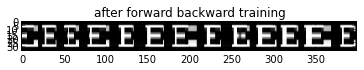

In [110]:
figsize(6,6)
imshow(centers[hmm_sample(A1,B1,400)].T)
title("after forward backward training")

For comparison, this is what we started with.

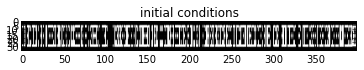

In [111]:
figsize(6,6)
imshow(centers[hmm_sample(A0,B0,400)].T)
title("initial conditions")

This looks a lot nicer than the other models, and spacing and size are much more controlled.
Keep in mind that we started with random weights!

However, this model still cannot represent relationships between different parts of a character:
if the first half of a character is "wide", then the second half should be as well, but that
relationship is not represented here.
To represent that, we would need more complex models (e.g., with multiple parallel paths).